By Linan Qiu [lq2137@columbia.edu](lq2137@columbia.edu)

This is the second part of the project on applying PCA to IRS.

# PCA on Curve Trade Rates

## Review on Curve Trades and Butterfly Trades

Refer to the introduction for a complete breakdown of curve trades and butterfly trades. As a reminder,

- Curve trades are bets on the slope of a specific section of the curve
- Butterflies are bets on the curvature of two specific sections of the curve.

## Data Collection

I employ most of the same data collection methods as in the previous section.

In [2]:
library(quantmod)
library(downloader)

terms = c(1, 2, 3, 4, 5, 7, 10, 30)
for (term in terms) {
  getSymbols(paste('DSWP', term, sep=''), src='FRED')
}

DSWP1 = DSWP1[!is.na(DSWP1)]
DSWP2 = DSWP2[!is.na(DSWP2)]
DSWP3 = DSWP3[!is.na(DSWP3)]
DSWP4 = DSWP4[!is.na(DSWP4)]
DSWP5 = DSWP5[!is.na(DSWP5)]
DSWP7 = DSWP7[!is.na(DSWP7)]
DSWP10 = DSWP10[!is.na(DSWP10)]
DSWP30 = DSWP30[!is.na(DSWP30)]

The yield of a curve trade is calculated as follow:

$$C = S_{0, t_2} - S_{0, t_1}$$

where $C$ is the curve trade rate, $S_{0,t_2}$ is the swap rate for an IRS of maturity $t_2$ and $S_{0, t_2}$ is the swap rate for an IRS of maturity $t_1$. Intuitively, we can think of this the forward rate from $t_1$ to $t_2$ and indeed it is. We select the following "tenors" (sections of the yield curve) to represent the whole yield curve. They are quoted as "XsYs" where we pay fix for X years and receive fix for Y years of IRS.

- 2s1s
- 3s1s
- 4s1s
- 5s1s
- 7s1s
- 10s2s
- 10s5s
- 30s10s

And select only the rates for the year to date.

In [4]:
# 2-1, 3-1, 4-1, 5-1, 7-1, 10-2, 10-5, 30-10
curve2_1 = DSWP2 - DSWP1
curve3_1 = DSWP3 - DSWP1
curve4_1 = DSWP4 - DSWP1
curve5_1 = DSWP5 - DSWP1
curve7_1 = DSWP7 - DSWP1
curve10_2 = DSWP10 - DSWP2
curve10_5 = DSWP10 - DSWP5
curve30_10 = DSWP30 - DSWP10

rates = cbind(curve2_1, curve3_1, curve4_1, curve5_1, curve7_1, curve10_2, curve10_5, curve30_10)
rates = last(rates, 250)
colnames(rates) = c('curve2y1y', 'curve3y1y', 'curve4y1y', 'curve5y1y', 'curve7y1y', 'curve10y2y', 'curve10y5y', 'curve30y10y')

As for the vanilla yields, I can plot a time series of the different curve rates. However, this chart isn't very telling, since I am measuring different ends of the curve.

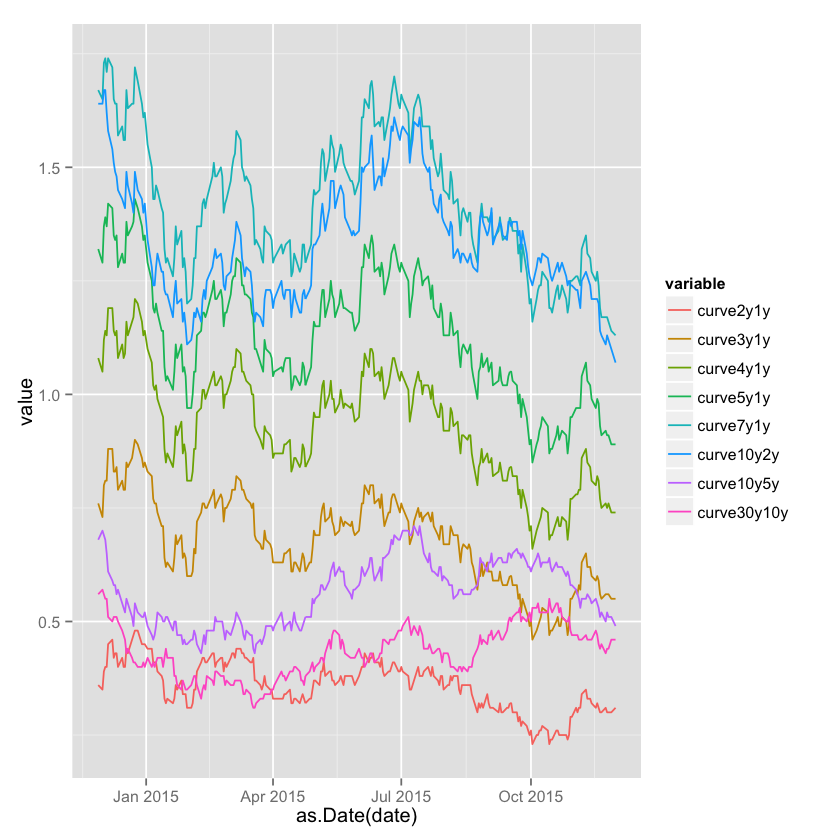

In [5]:
library(ggplot2)
library(reshape)
dataframe = data.frame(index(rates), rates)
colnames(dataframe) = c('date', 'curve2y1y', 'curve3y1y', 'curve4y1y', 'curve5y1y', 'curve7y1y', 'curve10y2y', 'curve10y5y', 'curve30y10y')
melted = melt(dataframe, id.vars='date')
plot = ggplot(data=melted, aes(x=as.Date(date), y=value, color=variable)) + geom_line()
plot

## Results

I perform PCA on the series as well using the covariance matrix of the time series.

In [7]:
pcadata = rates
colnames(pcadata) = c('curve2y1y', 'curve3y1y', 'curve4y1y', 'curve5y1y', 'curve7y1y', 'curve10y2y', 'curve10y5y', 'curve30y10y')
fit = princomp(pcadata, cor=FALSE, scores=TRUE)
summary(fit)

Importance of components:
                          Comp.1    Comp.2      Comp.3      Comp.4       Comp.5
Standard deviation     0.2775099 0.1294640 0.028713618 0.011572150 0.0048336969
Proportion of Variance 0.8126072 0.1768567 0.008699608 0.001413032 0.0002465373
Cumulative Proportion  0.8126072 0.9894639 0.998163497 0.999576529 0.9998230661
                             Comp.6       Comp.7 Comp.8
Standard deviation     2.971792e-03 2.817212e-03      0
Proportion of Variance 9.318811e-05 8.374576e-05      0
Cumulative Proportion  9.999163e-01 1.000000e+00      1

Again, the series has a high degree of covariance among the time series. This again should not be surprising, since they are all yield rates after all (though of different tenors) hence should be driven by the same macroeconomic factors.

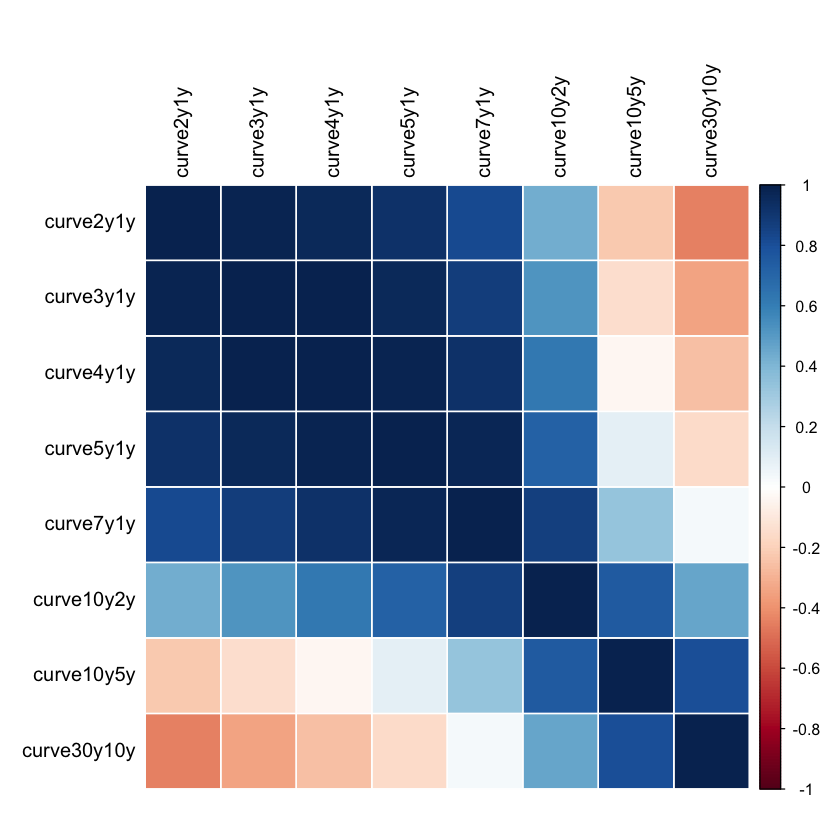

In [10]:
covariance_matrix = cor(pcadata)
require(corrplot)
corrplot(covariance_matrix, method='shade', type='full', shade.col=NA, tl.col='black')

However, what should be interesting to note is that some time series now have somewhat negative covariance with others. These happen to be between the far short end of the curve and the far long end (eg. 2s1s vs 30s10s). This makes sense, since the far end usually doesn't move as much as the short end, and sometimes in the opposite direction (slope).

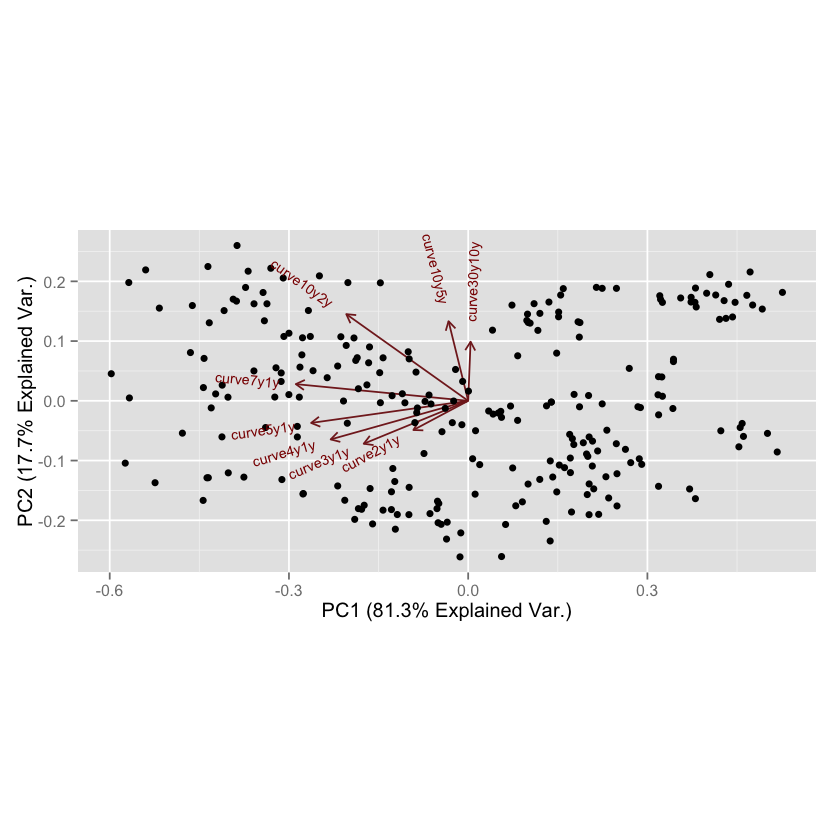

In [12]:
library(ggbiplot)
ggbiplot(fit, obs.scale=1, var.scale=1)

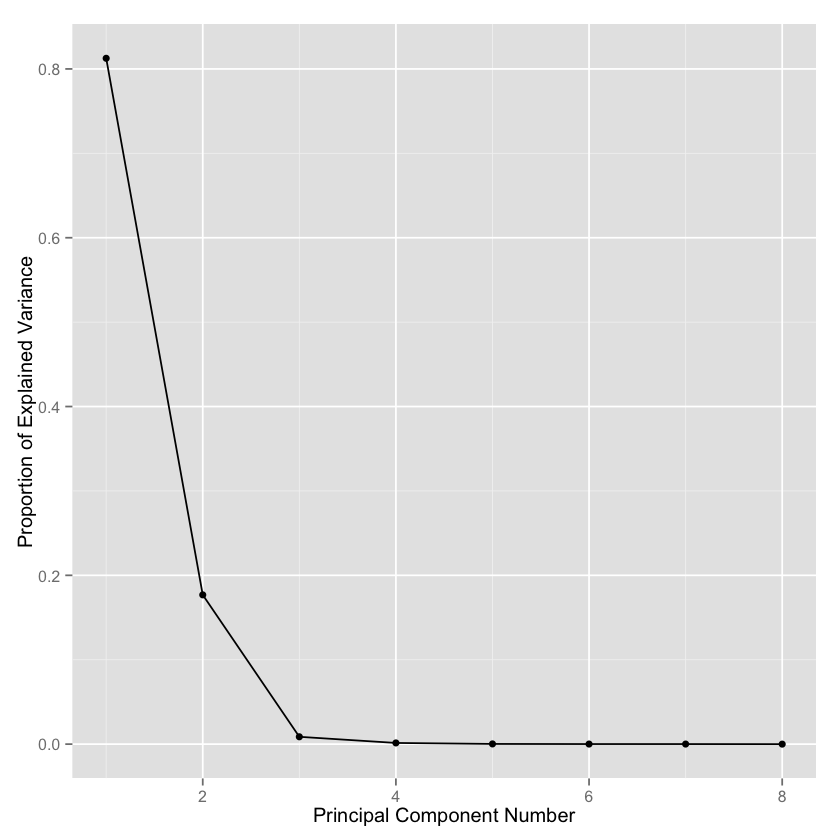

In [13]:
ggscreeplot(fit)

The first principal component accounts for 81.3% of variance, with the second principal component getting 17.7% and the third 0.87%. The first 3 principal components account for, cumulatively, 99.8% of all movements in the data. Hence, in terms of dimensionality reduction, the first 3 principal components are representative of the data.

We can plot the scores of the first 3 components across time.

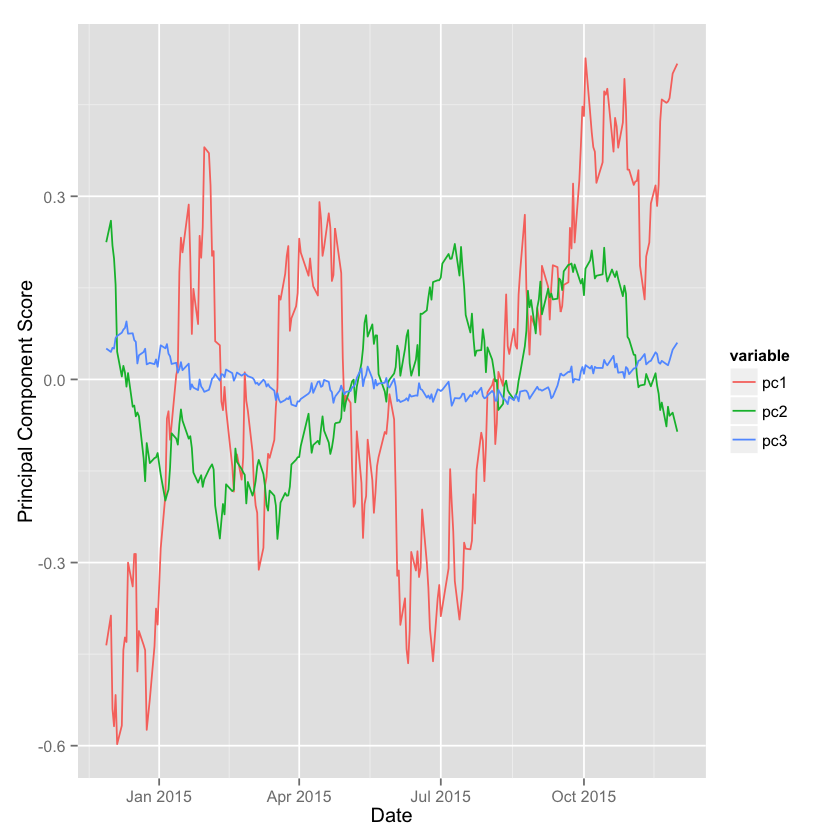

In [16]:
scores = fit$scores
scores_dataframe = data.frame(index(rates), scores)
colnames(scores_dataframe) = c('date', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8')
keeps = c('date', 'pc1', 'pc2', 'pc3')
scores_dataframe = scores_dataframe[keeps]
scores_melted = melt(scores_dataframe, id.vars='date')
plot = ggplot(data=scores_melted, aes(x=as.Date(date), y=value, color=variable)) + geom_line() + xlab('Date') + ylab('Principal Component Score')
plot

## Interpretation of Results

In [17]:
loadings = with(fit, unclass(loadings))
loadings

,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8
curve2y1y,-0.171227734,-0.195448923,0.004706401,0.667761277,0.255984666,-0.361642751,-0.200598804,-0.500000000
curve3y1y,-3.263336e-01,-2.874607e-01,1.814160e-01,2.487582e-01,-5.310257e-01,5.745447e-01,-3.224754e-01,3.785444e-13
curve4y1y,-4.295687e-01,-2.585274e-01,2.043599e-01,-1.301226e-01,-4.286356e-01,-4.860891e-01,5.195463e-01,-6.752862e-13
curve5y1y,-0.49071115,-0.14814235,0.05408491,-0.21436777,0.33797228,-0.25143465,-0.51081605,0.50000000
curve7y1y,-5.385355e-01,1.119178e-01,-1.587484e-01,1.153416e-01,4.549395e-01,4.507466e-01,4.988054e-01,-3.640491e-13
curve10y2y,-0.38081672,0.58044994,-0.17867132,-0.33936332,-0.20605357,-0.06584042,-0.27234639,-0.50000000
curve10y5y,-0.06133330,0.53314337,-0.22804983,0.54276573,-0.28804119,-0.17604852,0.03787086,0.50000000
curve30y10y,7.557077e-03,3.958458e-01,9.018019e-01,7.913918e-02,1.487753e-01,3.332223e-02,2.224416e-02,5.464379e-16
